<a href="https://colab.research.google.com/github/arjundussa65/Thesis-2020/blob/master/XLNET_with_undersampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# XLNet Finetuning with Dropout

This section of the file contains XLNet finetuning with dropout regularization.

In [ ]:
! pip install transformers

     |████████████████████████████████| 778kB 4.9MB/s 
     |████████████████████████████████| 1.1MB 25.5MB/s 
     |████████████████████████████████| 890kB 41.7MB/s 
     |████████████████████████████████| 3.0MB 42.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=962f2f54d3f6418c3e3a408745d02f3f053ed3cd303f64724e52d2412dbf67af
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
#mount google drive for colab usage
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
# importing the necessary libraries 


import torch.nn as nn

import os
import math

import torch
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, XLNetTokenizer, XLNetModel, XLNetLMHeadModel, XLNetConfig
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from torch.autograd.function import InplaceFunction
import torch.nn.init as init
import torch.nn.functional as F

from torch.nn import Parameter



In [ ]:

#For GPU usage
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla K80


In [ ]:
#Read file from Google Drive
df=pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/covid_labelled.csv", encoding='utf-8',usecols=['Text','Num_Sentiment'])

In [ ]:
#Mapping labels
df.loc[:,'sentiment'] = df.Num_Sentiment.map({-1:2,0:0,1:1})

In [ ]:
#Undersample the data 

X = df.Text.values.reshape(-1,1)
y = df.sentiment.values.reshape(-1,1)


sampler = RandomUnderSampler(ratio={0:3000,1:3000,2:3000})
X_rs, y_rs = sampler.fit_resample(X, y)

X=X_rs.flatten()
y=y_rs.flatten()

#X_train, X_val, y_train, y_val =\
 #   train_test_split(X, y, test_size=0.3, random_state=42)
#X_val, X_test, y_val, y_test =\
 #   train_test_split(X, y, test_size=0.4, random_state=42)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
l=np.array([X,y])
df = pd.DataFrame({'Text': X, 'sentiment': y}, columns=['Text', 'sentiment'])

In [ ]:
df.head()

,Text,sentiment
0,why am i not surprised dex j americans demand ...,0
1,scientists start connecting the dots from the ...,0
2,thank you for all who voted tell us your crazi...,0
3,check out our interview with at the link below,0
4,will virtual dating outlast the pandemic via ht,0


In [ ]:
#One hot encoding of target labels
one_hot = pd.get_dummies(df["sentiment"])
df.drop(['sentiment'],axis=1,inplace=True)
df = pd.concat([df,one_hot],axis=1)
df.head()

,Text,0,1,2
0,why am i not surprised dex j americans demand ...,1,0,0
1,scientists start connecting the dots from the ...,1,0,0
2,thank you for all who voted tell us your crazi...,1,0,0
3,check out our interview with at the link below,1,0,0
4,will virtual dating outlast the pandemic via ht,1,0,0


In [ ]:
#Split data into train and test

train,test =\
    train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
#Function for tokenizer
def plot_sentence_embeddings_length(text_list, tokenizer):
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t), text_list))
    tokenized_texts_len = list(map(lambda t: len(t), tokenized_texts))
    fig, ax = plt.subplots(figsize=(8, 5));
    ax.hist(tokenized_texts_len, bins=40);
    ax.set_xlabel("Length of Comment Embeddings");
    ax.set_ylabel("Number of Comments");
    return

In [ ]:
#Initialize tokenizer
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

In [ ]:
train_text_list = train["Text"].values
test_text_list = test["Text"].values

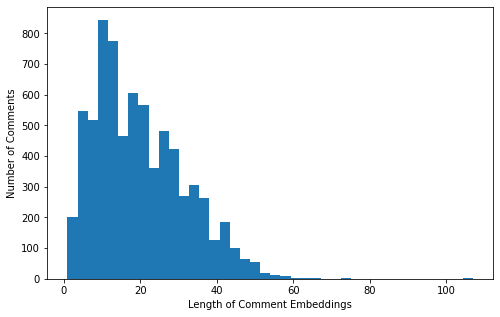

In [ ]:
plot_sentence_embeddings_length(train_text_list, tokenizer)

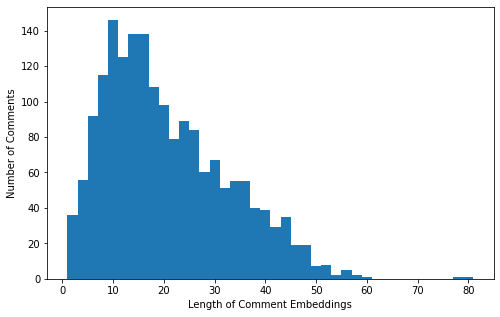

In [ ]:
plot_sentence_embeddings_length(test_text_list, tokenizer)

In [ ]:
def tokenize_inputs(text_list, tokenizer, num_embeddings=512):
    """
    Tokenizes the input text input into ids. Appends the appropriate special
    characters to the end of the text to denote end of sentence. Truncate or pad
    the appropriate sequence length.
    """
    # tokenize the text, then truncate sequence to the desired length minus 2 for
    # the 2 special characters
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t)[:num_embeddings-2], text_list))
    # convert tokenized text into numeric ids for the appropriate LM
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    # append special token "<s>" and </s> to end of sentence
    input_ids = [tokenizer.build_inputs_with_special_tokens(x) for x in input_ids]
    # pad sequences
    input_ids = pad_sequences(input_ids, maxlen=num_embeddings, dtype="long", truncating="post", padding="post")
    return input_ids

def create_attn_masks(input_ids):
    """
    Create attention masks to tell model whether attention should be applied to
    the input id tokens. Do not want to perform attention on padding tokens.
    """
    # Create attention masks
    attention_masks = []

    # Create a mask of 1s for each token followed by 0s for padding
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    return attention_masks

In [ ]:
# create input id tokens
train_input_ids = tokenize_inputs(train_text_list, tokenizer, num_embeddings=90)
train_input_ids

array([[   36,    27, 13219, ...,     0,     0,     0],
       [ 4242,    17,    23, ...,     0,     0,     0],
       [  108,    17, 18576, ...,     0,     0,     0],
       ...,
       [  319,   907,  1772, ...,     0,     0,     0],
       [  149,    63,   154, ...,     0,     0,     0],
       [   24,  5421,   117, ...,     0,     0,     0]])

In [ ]:
# create input id tokens
test_input_ids = tokenize_inputs(test_text_list, tokenizer, num_embeddings=90)
test_input_ids

array([[  611,    41,   463, ...,     0,     0,     0],
       [  281,   454,  1674, ...,     0,     0,     0],
       [  293,   546,    21, ...,     0,     0,     0],
       ...,
       [ 3466,    34,   426, ...,     0,     0,     0],
       [ 4755,    28,   830, ...,     0,     0,     0],
       [   17, 29316, 13738, ...,     0,     0,     0]])

In [ ]:
# create attention masks
train_attention_masks = create_attn_masks(train_input_ids)


In [ ]:
# create attention masks
test_attention_masks = create_attn_masks(test_input_ids)


In [ ]:
# add input ids and attention masks to the dataframe
train["features"] = train_input_ids.tolist()
train["masks"] = train_attention_masks

test["features"] = test_input_ids.tolist()
test["masks"] = test_attention_masks

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [ ]:
train.head()

,Text,0,1,2,features,masks
6317,it is unfortunately because of the and fewer p...,0,0,1,"[36, 27, 13219, 149, 20, 18, 21, 4801, 104, 53...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
740,absolutely suffocating hot temperatures compli...,1,0,0,"[4242, 17, 23, 7276, 3374, 2076, 1606, 6976, 2...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3781,if ibio succeeds it will solve a major humanit...,0,1,0,"[108, 17, 18576, 155, 5402, 23, 36, 53, 4929, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
7850,very irresponsible messaging from john rogers ...,0,0,1,"[172, 24605, 19534, 40, 17, 22116, 17, 17453, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2963,anti microbial so you never need to wash your ...,1,0,0,"[932, 17, 27129, 102, 44, 287, 214, 22, 8940, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [ ]:
test.head()

,Text,0,1,2,features,masks
7940,why are companies in your area like ripping pe...,0,0,1,"[611, 41, 463, 25, 73, 290, 115, 26889, 104, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1162,public health officer defends face covering order,1,0,0,"[281, 454, 1674, 4567, 23, 423, 4379, 374, 4, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
582,little news and pie,1,0,0,"[293, 546, 21, 11703, 4, 3, 0, 0, 0, 0, 0, 0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, ..."
4081,creative sweet hashtag face masks two filters ...,0,1,0,"[3932, 3353, 51, 409, 10585, 423, 17568, 87, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
8412,this book is so scary the truth is always scar...,0,0,1,"[52, 522, 27, 102, 13243, 18, 2092, 27, 426, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [ ]:
# train valid split
train, valid = train_test_split(train, test_size=0.4, random_state=42)

In [ ]:
X_train = train["features"].values.tolist()
X_valid = valid["features"].values.tolist()

train_masks = train["masks"].values.tolist()
valid_masks = valid["masks"].values.tolist()

label_cols = [0,1,2]
Y_train = train[label_cols].values.tolist()
Y_valid = valid[label_cols].values.tolist()

In [ ]:
# Convert all of our input ids and attention masks into 
# torch tensors, the required datatype for our model

X_train = torch.tensor(X_train)
X_valid = torch.tensor(X_valid)

Y_train = torch.tensor(Y_train, dtype=torch.float32)
Y_valid = torch.tensor(Y_valid, dtype=torch.float32)

train_masks = torch.tensor(train_masks, dtype=torch.long)
valid_masks = torch.tensor(valid_masks, dtype=torch.long)

In [ ]:
# Select a batch size for training
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on 
# memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(X_train, train_masks, Y_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data,\
                              sampler=train_sampler,\
                              batch_size=batch_size)

validation_data = TensorDataset(X_valid, valid_masks, Y_valid)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data,\
                                   sampler=validation_sampler,\
                                   batch_size=batch_size)

In [ ]:
#Function to train the model. 

def train(model, num_epochs,\
          optimizer,\
          train_dataloader, valid_dataloader,\
          model_save_path,\
          train_loss_set=[], valid_loss_set = [],\
          lowest_eval_loss=None, start_epoch=0,\
          device="cpu"
          ):
  """
  Train the model and save the model with the lowest validation loss
  """

  model.to(device)

  # trange is a tqdm wrapper around the normal python range
  for i in trange(num_epochs, desc="Epoch"):
    # if continue training from saved model
    actual_epoch = start_epoch + i

    # Training

    # Set our model to training mode (as opposed to evaluation mode)
    model.train()

    # Tracking variables
    tr_loss = 0
    num_train_samples = 0

    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      # Clear out the gradients (by default they accumulate)
      optimizer.zero_grad()
      # Forward pass
      loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
      # store train loss
      tr_loss += loss.item()
      num_train_samples += b_labels.size(0)
      # Backward pass
      loss.backward()
      # Update parameters and take a step using the computed gradient
      optimizer.step()
      #scheduler.step()

    # Update tracking variables
    epoch_train_loss = tr_loss/num_train_samples
    train_loss_set.append(epoch_train_loss)

    print("Train loss: {}".format(epoch_train_loss))

    # Validation

    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Tracking variables 
    eval_loss = 0
    num_eval_samples = 0

    # Evaluate data for one epoch
    for batch in valid_dataloader:
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      # Telling the model not to compute or store gradients,
      # saving memory and speeding up validation
      with torch.no_grad():
        # Forward pass, calculate validation loss
        loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        # store valid loss
        eval_loss += loss.item()
        num_eval_samples += b_labels.size(0)

    epoch_eval_loss = eval_loss/num_eval_samples
    valid_loss_set.append(epoch_eval_loss)

    print("Valid loss: {}".format(epoch_eval_loss))

    if lowest_eval_loss == None:
      lowest_eval_loss = epoch_eval_loss
      # save model
      save_model(model, model_save_path, actual_epoch,\
                 lowest_eval_loss, train_loss_set, valid_loss_set)
    else:
      if epoch_eval_loss < lowest_eval_loss:
        lowest_eval_loss = epoch_eval_loss
        # save model
        save_model(model, model_save_path, actual_epoch,\
                   lowest_eval_loss, train_loss_set, valid_loss_set)
    print("\n")

  return model, train_loss_set, valid_loss_set


def save_model(model, save_path, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist):
  """
  Save the model to the path directory provided
  """
  model_to_save = model.module if hasattr(model, 'module') else model
  checkpoint = {'epochs': epochs, \
                'lowest_eval_loss': lowest_eval_loss,\
                'state_dict': model_to_save.state_dict(),\
                'train_loss_hist': train_loss_hist,\
                'valid_loss_hist': valid_loss_hist
               }
  torch.save(checkpoint, save_path)
  print("Saving model at epoch {} with validation loss of {}".format(epochs,\
                                                                     lowest_eval_loss))
  return
  
def load_model(save_path):
  """
  Load the model from the path directory provided
  """
  checkpoint = torch.load(save_path)
  model_state_dict = checkpoint['state_dict']
  model = XLNetForMultiLabelSequenceClassification(num_labels=model_state_dict["classifier.weight"].size()[0])
  model.load_state_dict(model_state_dict)

  epochs = checkpoint["epochs"]
  lowest_eval_loss = checkpoint["lowest_eval_loss"]
  train_loss_hist = checkpoint["train_loss_hist"]
  valid_loss_hist = checkpoint["valid_loss_hist"]
  
  return model, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist

In [ ]:
torch.cuda.empty_cache()

In [ ]:
#Mixout code which mixes vanilla network and dropout

class Mixout(InplaceFunction):
    # target: a weight tensor mixes with a input tensor
    # A forward method returns 
    # [(1 - Bernoulli(1 - p) mask) * target + (Bernoulli(1 - p) mask) * input - p * target]/(1 - p) 
    # where p is a mix probability of mixout.
    # A backward returns the gradient of the forward method.
    # Dropout is equivalent to the case of target=None. 
    # I modified the code of dropout in PyTorch. 
    @staticmethod
    def _make_noise(input):
        return input.new().resize_as_(input)

    @classmethod
    def forward(cls, ctx, input, target=None, p=0.0, training=False, inplace=False):
        if p < 0 or p > 1:
            raise ValueError("A mix probability of mixout has to be between 0 and 1,"
                             " but got {}".format(p))
        if target is not None and input.size() != target.size():
            raise ValueError("A target tensor size must match with a input tensor size {},"
                             " but got {}". format(input.size(), target.size()))
        ctx.p = p    
        ctx.training = training
        
        if target is None:
            target = cls._make_noise(input)
            target.fill_(0)
        target = target.to(input.device)

        if inplace:
            ctx.mark_dirty(input)
            output = input
        else:
            output = input.clone()
        
        if ctx.p == 0 or not ctx.training:
            return output
        
        ctx.noise = cls._make_noise(input)
        if len(ctx.noise.size()) == 1:
            ctx.noise.bernoulli_(1 - ctx.p)
        else:
            ctx.noise[0].bernoulli_(1 - ctx.p)
            ctx.noise = ctx.noise[0].repeat(input.size()[0], *([1] * (len(input.size())-1)))
        ctx.noise.expand_as(input)
        
        if ctx.p == 1:
            output = target.clone()
        else:
            output = ((1 - ctx.noise) * target + ctx.noise * output - ctx.p * target) / (1 - ctx.p)
        return output
        
    @staticmethod
    def backward(ctx, grad_output):
        if ctx.p > 0 and ctx.training:
            return grad_output * ctx.noise, None, None, None, None
        else:
            return grad_output, None, None, None, None

def mixout(input, target=None, p=0.0, training=False, inplace=False):
    return Mixout.apply(input, target, p, training, inplace)

In [ ]:
#Mixlinear module function

#from mixout import mixout

class MixLinear(torch.nn.Module):
    __constants__ = ['bias', 'in_features', 'out_features']
    # If target is None, nn.Sequential(nn.Linear(m, n), MixLinear(m', n', p)) 
    # is equivalent to nn.Sequential(nn.Linear(m, n), nn.Dropout(p), nn.Linear(m', n')).
    # If you want to change a dropout layer to a mixout layer, 
    # you should replace nn.Linear right after nn.Dropout(p) with Mixout(p) 
    def __init__(self, in_features, out_features, bias=True, target=None, p=0.0):
        super(MixLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.Tensor(out_features, in_features))
        if bias:
            self.bias = Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()
        self.target = target
        self.p = p
    
    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)
            
    def forward(self, input):
        return F.linear(input, mixout(self.weight, self.target, 
                                      self.p, self.training), self.bias)

    def extra_repr(self):
        type = 'drop' if self.target is None else 'mix' 
        return '{}={}, in_features={}, out_features={}, bias={}'.format(type+"out", self.p,
            self.in_features, self.out_features, self.bias is not None)

In [ ]:
#Initializee XLNet model and add classifier 
        
class XLNetForMultiLabelSequenceClassification(torch.nn.Module):
  
  def __init__(self, num_labels=2):
    super(XLNetForMultiLabelSequenceClassification, self).__init__()
    self.num_labels = num_labels
    self.xlnet = XLNetModel.from_pretrained('xlnet-base-cased')
    # Instantiate an one-layer feed-forward classifier
    self.classifier = self.classifier= nn.Linear(768, num_labels)
    

    torch.nn.init.xavier_normal_(self.classifier.weight)

  def forward(self, input_ids, token_type_ids=None,\
              attention_mask=None, labels=None):
    # last hidden layer
    last_hidden_state = self.xlnet(input_ids=input_ids,\
                                   attention_mask=attention_mask,\
                                   token_type_ids=token_type_ids)
    # pool the outputs into a mean vector
    mean_last_hidden_state = self.pool_hidden_state(last_hidden_state)
 #   mean_last_hidden_state = self.activation(mean_last_hidden_state)
 #   mean_last_hidden_state = self.dropout(mean_last_hidden_state)
    logits = self.classifier(mean_last_hidden_state)
        
    if labels is not None:
      loss_fct = BCEWithLogitsLoss()
      loss = loss_fct(logits.view(-1, self.num_labels),\
                      labels.view(-1, self.num_labels))
      return loss
    else:
      return logits
    
  def freeze_xlnet_decoder(self):
    """
    Freeze XLNet weight parameters. They will not be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = False
    
  def unfreeze_xlnet_decoder(self):
    """
    Unfreeze XLNet weight parameters. They will be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = True
    
  def pool_hidden_state(self, last_hidden_state):
    """
    Pool the output vectors into a single mean vector 
    """
    last_hidden_state = last_hidden_state[0]
    mean_last_hidden_state = torch.mean(last_hidden_state, 1)
    return mean_last_hidden_state
    
model2 = XLNetForMultiLabelSequenceClassification(num_labels=len(Y_train[0]))
#model = torch.nn.DataParallel(model)
model2.cuda()

XLNetForMultiLabelSequenceClassification(
  (xlnet): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), ep

In [ ]:
#Initialize optimizer
optimizer = AdamW(model2.parameters(), lr=2e-5, weight_decay=0.01, correct_bias=False)
#scheduler = WarmupLinearSchedule(optimizer, warmup_steps=num_warmup_steps, t_total=num_total_steps)  # PyTorch scheduler

In [ ]:
#Define training epocs and train the model
num_epochs=2

cwd = os.getcwd()
model_save_path = output_model_file = os.path.join(cwd, "gdrive/My Drive/Colab Notebooks/xlnet_tweet_undersamp.bin")
model, train_loss_set, valid_loss_set = train(model=model2,\
                                              num_epochs=num_epochs,\
                                              optimizer=optimizer,\
                                              train_dataloader=train_dataloader,\
                                              valid_dataloader=validation_dataloader,\
                                              model_save_path=model_save_path,\
                                              device="cuda")

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.023685469174826588
Valid loss: 0.019700101928578483


Epoch:  50%|█████     | 1/2 [03:40<03:40, 220.33s/it]

Saving model at epoch 0 with validation loss of 0.019700101928578483


Train loss: 0.018241517197478702
Valid loss: 0.014596843998879195


Epoch: 100%|██████████| 2/2 [07:17<00:00, 218.97s/it]

Saving model at epoch 1 with validation loss of 0.014596843998879195




Text(0.5, 1.0, 'Loss vs Number of Epochs')

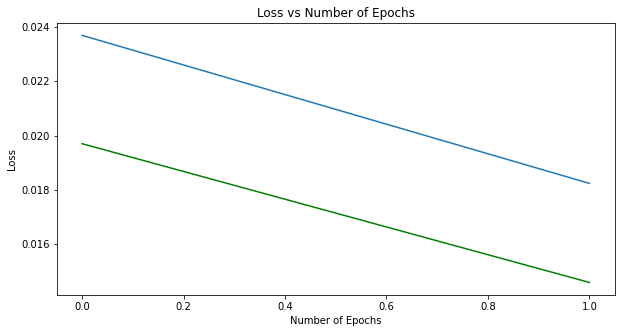

In [ ]:
# Plot loss vs number of epochs
num_epochs = np.arange(len(train_loss_set))

fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(train_loss_set), label="Train Loss")
ax.plot(num_epochs, np.array(valid_loss_set), 'g-', label="Valid Loss")
#ax1.plot(episode_record, lose_record, 'r-', label="Lose %")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Loss")
ax.set_title("Loss vs Number of Epochs")

In [ ]:
cwd = os.getcwd()
model_save_path = output_model_file = os.path.join(cwd, "gdrive/My Drive/Colab Notebooks/xlnet_tweet_undersamp.bin")
model, start_epoch, lowest_eval_loss, train_loss_hist, valid_loss_hist = load_model(model_save_path)

In [ ]:
#Function to predict the model on test data
def generate_predictions(model, df, num_labels, device="cpu", batch_size=32):
  num_iter = math.ceil(df.shape[0]/batch_size)
  
  pred_probs = np.array([]).reshape(0, num_labels)
  
  model.to(device)
  model.eval()
  
  for i in range(num_iter):
    df_subset = df.iloc[i*batch_size:(i+1)*batch_size,:]
    X = df_subset["features"].values.tolist()
    masks = df_subset["masks"].values.tolist()
    X = torch.tensor(X)
    masks = torch.tensor(masks, dtype=torch.long)
    X = X.to(device)
    masks = masks.to(device)
    with torch.no_grad():
      logits = model(input_ids=X, attention_mask=masks)
      logits = logits.sigmoid().detach().cpu().numpy()
      pred_probs = np.vstack([pred_probs, logits])
  
  return pred_probs

In [ ]:
num_labels = len(label_cols)
pred_probs = generate_predictions(model, test, num_labels, device="cuda", batch_size=32)
pred_probs=np.round(pred_probs)

In [ ]:
pred_probs

array([[0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

In [ ]:
a=np.round(pred_probs)

In [ ]:
#Print accuracy score
y_test=test.iloc[:,1:4].values
accuracy_score(y_test,a)

,Text,0,1,2,Neutral,Positive,Negative
7940,why are companies in your area like ripping pe...,0,0,1,0.0,0.0,1.0
1162,public health officer defends face covering order,1,0,0,1.0,0.0,0.0
582,little news and pie,1,0,0,1.0,0.0,0.0
4081,creative sweet hashtag face masks two filters ...,0,1,0,0.0,1.0,0.0
8412,this book is so scary the truth is always scar...,0,0,1,0.0,0.0,1.0


In [ ]:
#Print classification report
print('\nClassification Report\n')
y_pred=np.round(pred_probs)
print(classification_report(y_test, a, target_names=['Negative', 'Neutral', 'Positive']))

In [ ]:
#Print confusion matrix
print(confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1)))


# Finetune XLNet with Mixout Regularization

In [ ]:
#Initialize XLNet model for multiclass classification and add classifier and convert the linear layer to mixlinear with mixout percentage added 
        
class XLNetForMultiLabelSequenceClassification(torch.nn.Module):
  
  def __init__(self, num_labels=2):
    super(XLNetForMultiLabelSequenceClassification, self).__init__()
    self.num_labels = num_labels
    self.xlnet = XLNetModel.from_pretrained('xlnet-base-cased')
    # Instantiate an one-layer feed-forward classifier
    self.classifier = torch.nn.Linear(768, num_labels)
    

    torch.nn.init.xavier_normal_(self.classifier.weight)

  def forward(self, input_ids, token_type_ids=None,\
              attention_mask=None, labels=None):
    # last hidden layer
    last_hidden_state = self.xlnet(input_ids=input_ids,\
                                   attention_mask=attention_mask,\
                                   token_type_ids=token_type_ids)
    # pool the outputs into a mean vector
    mean_last_hidden_state = self.pool_hidden_state(last_hidden_state)
 #   mean_last_hidden_state = self.activation(mean_last_hidden_state)
 #   mean_last_hidden_state = self.dropout(mean_last_hidden_state)
    logits = self.classifier(mean_last_hidden_state)
        
    if labels is not None:
      loss_fct = BCEWithLogitsLoss()
      loss = loss_fct(logits.view(-1, self.num_labels),\
                      labels.view(-1, self.num_labels))
      return loss
    else:
      return logits
    
  def freeze_xlnet_decoder(self):
    """
    Freeze XLNet weight parameters. They will not be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = False
    
  def unfreeze_xlnet_decoder(self):
    """
    Unfreeze XLNet weight parameters. They will be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = True
    
  def pool_hidden_state(self, last_hidden_state):
    """
    Pool the output vectors into a single mean vector 
    """
    last_hidden_state = last_hidden_state[0]
    mean_last_hidden_state = torch.mean(last_hidden_state, 1)
    return mean_last_hidden_state
    
model3 = XLNetForMultiLabelSequenceClassification(num_labels=len(Y_train[0]))
for name, module in model3.named_modules():
    if name in ['dropout'] and isinstance(module, nn.Dropout):
        setattr(model3, name, nn.Dropout(0))
    if name in ['classifier'] and isinstance(module, nn.Linear):
        target_state_dict = module.state_dict()
        bias = True if module.bias is not None else False
        new_module = MixLinear(module.in_features, module.out_features, 
                               bias, target_state_dict['weight'], 0.5)
        new_module.load_state_dict(target_state_dict)
        setattr(model3, name, new_module)
model3.cuda()

In [ ]:
#Initialize optimizer
optimizer = AdamW(model3.parameters(), lr=2e-5, weight_decay=0.01, correct_bias=False)
#scheduler = WarmupLinearSchedule(optimizer, warmup_steps=num_warmup_steps, t_total=num_total_steps)  # PyTorch scheduler

In [ ]:
#Train the model 
num_epochs=2

cwd = os.getcwd()
model_save_path = output_model_file = os.path.join(cwd, "gdrive/My Drive/Colab Notebooks/xlnet_tweet_undersamp_mix.bin")
model, train_loss_set, valid_loss_set = train(model=model3,\
                                              num_epochs=num_epochs,\
                                              optimizer=optimizer,\
                                              train_dataloader=train_dataloader,\
                                              valid_dataloader=validation_dataloader,\
                                              model_save_path=model_save_path,\
                                              device="cuda")

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.053820684883329604
Valid loss: 0.05412008166313172


Epoch:  50%|█████     | 1/2 [03:36<03:36, 216.67s/it]

Saving model at epoch 0 with validation loss of 0.05412008166313172


Train loss: 0.05350122622869633


Epoch: 100%|██████████| 2/2 [07:10<00:00, 215.47s/it]

Valid loss: 0.05412008166313172




In [ ]:
# Plot loss vs number of epochs
num_epochs = np.arange(len(train_loss_set))

fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(train_loss_set), label="Train Loss")
ax.plot(num_epochs, np.array(valid_loss_set), 'g-', label="Valid Loss")
#ax1.plot(episode_record, lose_record, 'r-', label="Lose %")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Loss")
ax.set_title("Loss vs Number of Epochs")

In [ ]:
cwd = os.getcwd()
model_save_path = output_model_file = os.path.join(cwd, "gdrive/My Drive/Colab Notebooks/xlnet_tweet_undersampling_mix.bin")
model, start_epoch, lowest_eval_loss, train_loss_hist, valid_loss_hist = load_model(model_save_path)

In [ ]:
#Function to generate predictions on test data

def generate_predictions(model, df, num_labels, device="cpu", batch_size=32):
  num_iter = math.ceil(df.shape[0]/batch_size)
  
  pred_probs = np.array([]).reshape(0, num_labels)
  
  model.to(device)
  model.eval()
  
  for i in range(num_iter):
    df_subset = df.iloc[i*batch_size:(i+1)*batch_size,:]
    X = df_subset["features"].values.tolist()
    masks = df_subset["masks"].values.tolist()
    X = torch.tensor(X)
    masks = torch.tensor(masks, dtype=torch.long)
    X = X.to(device)
    masks = masks.to(device)
    with torch.no_grad():
      logits = model(input_ids=X, attention_mask=masks)
      logits = logits.sigmoid().detach().cpu().numpy()
      pred_probs = np.vstack([pred_probs, logits])
  
  return pred_probs

In [ ]:
#Generate predictions
num_labels = len(label_cols)
pred_probs = generate_predictions(model, test, num_labels, device="cuda", batch_size=32)
pred_probs

In [ ]:
s=np.round(pred_probs)

In [ ]:
#Print accuracy score
y_test=test.iloc[:,1:4].values
accuracy_score(y_test,s)

In [ ]:
#Print classification report
print('\nClassification Report\n')
y_pred=np.round(pred_probs)
print(classification_report(y_test, s, target_names=['Negative', 'Neutral', 'Positive']))

In [ ]:
#Print confusion matrix
print(confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1)))